# Analysis for *Generating Event Descriptions*

In [84]:
import os
import re
import numpy as np
import pandas as pd
import seaborn as sns
import arviz

from typing import Literal, Callable
from dataclasses import dataclass
from glob import glob
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression
from patsy import dmatrix
from cmdstanpy import CmdStanModel, CmdStanMCMC, from_csv

## Experiment 1: Naturalness

In [2]:
nat_fnames = [
    "naturalness_llama-propbanksenses.csv",
    "naturalness_llama-llamasenses.csv",
    "naturalness_reddit.csv",
    "naturalness_manual.csv"
]

data_nat = []

for fname in nat_fnames:
    df = pd.read_csv(f"data/{fname}")

    generation_method = fname.replace("naturalness_", "").strip(".csv")

    if generation_method == "manual":
        df["generation_method_type"] = "manual"
        df["generation_method_subtype"] = "manual"
        df = df.query("sentence_type == 'target'")
        df["generation_method"] = "manual_" + df.naturalness + "_" + df.typicality
    else:
        df["generation_method_type"] = "automated"
        df["generation_method_subtype"] = generation_method
        df["generation_method"] = df[["sentence_type", "naturalness", "typicality"]].agg(
            lambda x: "manual_" + x.naturalness + "_" + x.typicality if x.sentence_type == "calibration" else generation_method,
            axis=1
        )

    data_nat.append(df)

data_nat = pd.concat(data_nat)

data_nat["surprisal_z"] = (data_nat.surprisal - data_nat.surprisal.mean())/data_nat.surprisal.std()
data_nat["freq_z"] = (data_nat.freq - data_nat.freq.mean())/data_nat.freq.std()

data_nat

,rater_id,sentence,rating,sense,verb,typicality,naturalness,sentence_type,surprisal,freq,verbnet_class,generation_method_type,generation_method_subtype,generation_method,surprisal_z,freq_z
0,83bda277-9b4f-4c6e-a23b-a79ece20cc5c,The baby arranged the something.,50.0,arrange.01: build,arrange,typical,unnatural,calibration,127.474388,2289,build,automated,llama-propbanksense,manual_unnatural_typical,-0.730774,-0.240193
1,8bc64c84-3e28-4f83-abaf-e585ff40ffe5,The baby arranged the something.,0.0,arrange.01: build,arrange,typical,unnatural,calibration,127.474388,2289,build,automated,llama-propbanksense,manual_unnatural_typical,-0.730774,-0.240193
2,f09582f5-d39c-41eb-ab67-ff696f2c3459,The baby arranged the something.,22.0,arrange.01: build,arrange,typical,unnatural,calibration,127.474388,2289,build,automated,llama-propbanksense,manual_unnatural_typical,-0.730774,-0.240193
3,e41ede6f-b8a8-4424-a276-520d63d0af85,The baby arranged the something.,0.0,arrange.01: build,arrange,typical,unnatural,calibration,127.474388,2289,build,automated,llama-propbanksense,manual_unnatural_typical,-0.730774,-0.240193
4,03eaf938-1208-40ce-9b0b-bb58cc6048c9,The baby arranged the something.,0.0,arrange.01: build,arrange,typical,unnatural,calibration,127.474388,2289,build,automated,llama-propbanksense,manual_unnatural_typical,-0.730774,-0.240193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6815,48938107-ae25-4ac5-af1f-f5552d1228a9,The after tore the brick.,25.0,"tear.01: to pull apart, separate forcefully",tear,atypical,unnatural,target,194.907486,1030,hurt,manual,manual,manual_unnatural_atypical,0.885373,-1.088339
6816,48938107-ae25-4ac5-af1f-f5552d1228a9,The athlete threw the javelin.,100.0,"throw.01: throw, sending through the air, manu...",throw,typical,natural,target,220.600510,3679,throw,manual,manual,manual_natural_typical,1.501149,0.696203
6817,48938107-ae25-4ac5-af1f-f5552d1228a9,The jellyfish threw the javelin.,92.0,"throw.01: throw, sending through the air, manu...",throw,atypical,natural,target,189.328308,3679,throw,manual,manual,manual_natural_atypical,0.751658,0.696203
6818,48938107-ae25-4ac5-af1f-f5552d1228a9,The athlete threw the while.,38.0,"throw.01: throw, sending through the air, manu...",throw,typical,unnatural,target,224.713104,3679,throw,manual,manual,manual_unnatural_typical,1.599714,0.696203


### Participant filtration

Some participants did not complete the survey. We remove these participants.

In [3]:
def filter_participants(data, expected_counts: dict[str, int]) -> pd.DataFrame:
    """Filter participants who did not complete the task"""
    actual_counts = data.groupby("generation_method_subtype").rater_id.value_counts().reset_index()

    exclude_participants = [
        r.rater_id for _, r in actual_counts.iterrows()
        if r["count"] != expected_counts[r.generation_method_subtype]
    ]

    return data[~data.rater_id.isin(exclude_participants)]

In [4]:
expected_counts_nat = {
    "llama-llamasense": 97,
    "llama-propbanksense": 97,
    "manual": 124,
    "reddit": 72
}

data_nat = filter_participants(data_nat, expected_counts_nat)

data_nat

,rater_id,sentence,rating,sense,verb,typicality,naturalness,sentence_type,surprisal,freq,verbnet_class,generation_method_type,generation_method_subtype,generation_method,surprisal_z,freq_z
0,83bda277-9b4f-4c6e-a23b-a79ece20cc5c,The baby arranged the something.,50.0,arrange.01: build,arrange,typical,unnatural,calibration,127.474388,2289,build,automated,llama-propbanksense,manual_unnatural_typical,-0.730774,-0.240193
1,8bc64c84-3e28-4f83-abaf-e585ff40ffe5,The baby arranged the something.,0.0,arrange.01: build,arrange,typical,unnatural,calibration,127.474388,2289,build,automated,llama-propbanksense,manual_unnatural_typical,-0.730774,-0.240193
2,f09582f5-d39c-41eb-ab67-ff696f2c3459,The baby arranged the something.,22.0,arrange.01: build,arrange,typical,unnatural,calibration,127.474388,2289,build,automated,llama-propbanksense,manual_unnatural_typical,-0.730774,-0.240193
3,e41ede6f-b8a8-4424-a276-520d63d0af85,The baby arranged the something.,0.0,arrange.01: build,arrange,typical,unnatural,calibration,127.474388,2289,build,automated,llama-propbanksense,manual_unnatural_typical,-0.730774,-0.240193
4,03eaf938-1208-40ce-9b0b-bb58cc6048c9,The baby arranged the something.,0.0,arrange.01: build,arrange,typical,unnatural,calibration,127.474388,2289,build,automated,llama-propbanksense,manual_unnatural_typical,-0.730774,-0.240193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6815,48938107-ae25-4ac5-af1f-f5552d1228a9,The after tore the brick.,25.0,"tear.01: to pull apart, separate forcefully",tear,atypical,unnatural,target,194.907486,1030,hurt,manual,manual,manual_unnatural_atypical,0.885373,-1.088339
6816,48938107-ae25-4ac5-af1f-f5552d1228a9,The athlete threw the javelin.,100.0,"throw.01: throw, sending through the air, manu...",throw,typical,natural,target,220.600510,3679,throw,manual,manual,manual_natural_typical,1.501149,0.696203
6817,48938107-ae25-4ac5-af1f-f5552d1228a9,The jellyfish threw the javelin.,92.0,"throw.01: throw, sending through the air, manu...",throw,atypical,natural,target,189.328308,3679,throw,manual,manual,manual_natural_atypical,0.751658,0.696203
6818,48938107-ae25-4ac5-af1f-f5552d1228a9,The athlete threw the while.,38.0,"throw.01: throw, sending through the air, manu...",throw,typical,unnatural,target,224.713104,3679,throw,manual,manual,manual_unnatural_typical,1.599714,0.696203


### Model fitting

To analyze the data, we use a generlized linear mixed effects model with an ordered beta link. This model is implemented in `scripts/analysis/models/ordered-beta.stan`. 

In [5]:
model = CmdStanModel(stan_file="scripts/analysis/models/ordered-beta.stan")

To fit this model to our data, we need to map it into the format assumd by the model's `data` block.

```stan
data {
  int<lower=1> N_resp;                             // number of responses
  int<lower=1> N_subj;                             // number of subjects
  int<lower=1> N_verb;                             // number of verbs
  int<lower=1> N_sense;                            // number of senses
  int<lower=1> N_item;                             // number of items
  int<lower=1> N_fixed;                            // number of fixed predictors
  int<lower=1> N_by_subj;                          // number of random by-subject predictors
  int<lower=1> N_by_verb;                          // number of random by-verb predictors
  int<lower=1> N_by_sense;                         // number of random by-sense predictors
  int<lower=1> N_by_item;                          // number of random by-item predictors
  matrix[N_resp,N_fixed] fixed_predictors;         // predictors including intercept
  matrix[N_resp,N_by_subj] by_subj_predictors;     // by-subject predictors including intercept
  matrix[N_resp,N_by_verb] by_verb_predictors;     // by-verb predictors including intercept
  matrix[N_resp,N_by_sense] by_sense_predictors;   // by-sense predictors including intercept
  matrix[N_resp,N_by_item] by_item_predictors;     // by-item predictors including intercept
  array[N_resp] int<lower=1,upper=N_subj> subj;    // subject who gave response n
  array[N_resp] int<lower=1,upper=N_verb> verb;    // verb corresponding to response n
  array[N_resp] int<lower=1,upper=N_sense> sense;  // sense corresponding to response n
  array[N_resp] int<lower=1,upper=N_item> item;    // item corresponding to response n
  array[N_resp] int<lower=1,upper=3> resp_bin;     // whether a response is 0=1, (0, 1)=2, or 1=2
  array[N_resp] real<lower=0,upper=1> resp;        // [0, 1] responses                                    
}
```

In [6]:
def bin_response(x: float) -> int:
    """Bin the response by whether it is an endpoint (0, 1) or not."""
    if x == 0.0:
        return 1
    elif x == 1.0:
        return 3
    else:
        return 2

def prepare_data(
    data: pd.DataFrame, 
    fixed_formula: str,
    by_subj_formula: str,
    by_verb_formula: str,
    by_sense_formula: str,
    by_item_formula: str,
    item_cols: list[str],
    sense_cols: list[str],
    subj_cols: list[str] = ["rater_id"], 
    verb_cols: list[str] = ["verb"], 
    resp_col: str = "rating",
) -> tuple[dict[str, int | np.ndarray], np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    # scale the responses to [0, 1]
    resp = data[resp_col] / 100

    # bin the responses
    resp_bin = resp.map(bin_response)

    # construct the design matrices
    fixed_predictors = dmatrix(fixed_formula, data, return_type="dataframe")
    by_subj_predictors = dmatrix(by_subj_formula, data, return_type="dataframe")
    by_verb_predictors = dmatrix(by_verb_formula, data, return_type="dataframe")
    by_sense_predictors = dmatrix(by_sense_formula, data, return_type="dataframe")
    by_item_predictors = dmatrix(by_item_formula, data, return_type="dataframe")

    # hash the items and subjects
    subjid = data[subj_cols].agg('-'.join, axis=1).astype("category")
    verbid = data[verb_cols].agg('-'.join, axis=1).astype("category")
    senseid = data[sense_cols].agg('-'.join, axis=1).astype("category")
    itemid = data[item_cols].agg('-'.join, axis=1).astype("category")
    
    # determine whether the subject is a discrete responder
    disc_responder = data[[resp_col]].isin([0, 100])
    disc_responder["subjid"] = subjid
    disc_responder = disc_responder.groupby("subjid")[resp_col].all()

    data_stan = {
        "N_resp": data.shape[0],
        "N_subj": subjid.cat.codes.max() + 1,
        "N_verb": verbid.cat.codes.max() + 1,
        "N_sense": senseid.cat.codes.max() + 1,
        "N_item": itemid.cat.codes.max() + 1,
        "N_fixed": fixed_predictors.shape[1],
        "N_by_subj": by_subj_predictors.shape[1],
        "N_by_verb": by_verb_predictors.shape[1],
        "N_by_sense": by_sense_predictors.shape[1],
        "N_by_item": by_item_predictors.shape[1],
        "fixed_predictors": fixed_predictors.values,
        "by_subj_predictors": by_subj_predictors.values,
        "by_verb_predictors": by_verb_predictors.values,
        "by_sense_predictors": by_sense_predictors.values,
        "by_item_predictors": by_item_predictors.values,
        "subj": subjid.cat.codes.values + 1,
        "verb": verbid.cat.codes.values + 1,
        "sense": senseid.cat.codes.values + 1,
        "item": itemid.cat.codes.values + 1,
        "resp_bin": resp_bin.values.astype(int),
        "resp": resp.values
    }

    return (
        data_stan, 
        fixed_predictors.columns.values, 
        by_subj_predictors.columns.values,
        by_verb_predictors.columns.values,
        by_sense_predictors.columns.values,
        by_item_predictors.columns.values,
    )

The estimates for the distribution over fixed and random effects reported in the paper are extracted from the model fits using:

In [7]:
def fixed_coef_stats(fit: CmdStanMCMC, coef_names: list[str]) -> pd.DataFrame:
    fixed_coefs = fit.stan_variable("fixed_coefs")

    posterior_means = fixed_coefs.mean(axis=0)
    
    stats = pd.DataFrame(
        np.quantile(fixed_coefs, [0.025, 0.05, 0.95,  0.975], axis=0).T, 
        index=coef_names,
        columns=["2.5%", "5%", "95%", "97.5%"]
    )

    stats["post_mean"] = posterior_means
    
    stats["p"] = np.mean(
        np.sign(posterior_means)[None,:] != np.sign(fixed_coefs), 
        axis=0
    )

    return stats[["post_mean", "2.5%", "5%", "95%", "97.5%", "p"]]

def random_coef_stats(
    fit: CmdStanMCMC, 
    var_name: Literal[
        "subj_cov", "subj_corr", 
        "verb_cov", "verb_corr", 
        "sense_cov", "sense_corr", 
        "item_cov", "item_corr"
    ], 
    coef_names: list[str]
) -> pd.DataFrame:
    matrices = fit.stan_variable(var_name)
    posterior_means = pd.DataFrame(
        matrices.mean(axis=0),
        index=coef_names,
        columns=coef_names
    )

    return posterior_means


And the actual model fits are done using:

In [22]:
@dataclass
class ModelResults:
    fit: CmdStanMCMC
    fixed_coefs: pd.DataFrame
    subj_cov:  pd.DataFrame
    verb_cov:  pd.DataFrame
    sense_cov: pd.DataFrame
    item_cov:  pd.DataFrame
    subj_corr: pd.DataFrame
    verb_corr: pd.DataFrame
    sense_corr: pd.DataFrame
    item_corr: pd.DataFrame

def fit_hmc(
    data: pd.DataFrame,
    fixed_formula: str, 
    by_subj_formula: str,
    by_verb_formula: str,
    by_sense_formula: str,
    by_item_formula: str,  
    item_cols: list[str],
    subj_cols: list[str],
    verb_cols: list[str],
    sense_cols: list[str], 
    seed: int = 30298,
    **kwargs
) -> ModelResults:
    data_stan, fixed_predictors, by_subj_predictors, by_verb_predictors, by_sense_predictors, by_item_predictors = prepare_data(
        data,
        fixed_formula=fixed_formula,
        by_subj_formula=by_subj_formula,
        by_verb_formula=by_verb_formula,
        by_sense_formula=by_sense_formula,
        by_item_formula=by_item_formula, 
        subj_cols=subj_cols,
        verb_cols=verb_cols,
        sense_cols=sense_cols,
        item_cols=item_cols
    )

    fit = model.sample(
        data=data_stan,
        seed=seed,
        **kwargs
    )

    return ModelResults(
        fit = fit, 
        fixed_coefs = fixed_coef_stats(fit, fixed_predictors),
        subj_cov = random_coef_stats(fit, "subj_cov", by_subj_predictors),
        verb_cov = random_coef_stats(fit, "verb_cov", by_verb_predictors),
        sense_cov = random_coef_stats(fit, "sense_cov", by_sense_predictors),
        item_cov = random_coef_stats(fit, "item_cov", by_item_predictors),
        subj_corr = random_coef_stats(fit, "subj_corr", by_subj_predictors),
        verb_corr = random_coef_stats(fit, "verb_corr", by_verb_predictors),
        sense_corr = random_coef_stats(fit, "sense_corr", by_sense_predictors),
        item_corr = random_coef_stats(fit, "item_corr", by_item_predictors)
    )

Because we don't want ot have to rerun the models if we already have them cached, we'll also define a method for loading a fit from CSVs dumped by `cmdstanpy`.

In [34]:
def load_fit(
    path: str, 
    data: pd.DataFrame,
    fixed_formula: str, 
    by_subj_formula: str,
    by_verb_formula: str,
    by_sense_formula: str,
    by_item_formula: str,  
    item_cols: list[str],
    subj_cols: list[str],
    verb_cols: list[str],
    sense_cols: list[str],
) -> ModelResults:
    _, fixed_predictors, by_subj_predictors, by_verb_predictors, by_sense_predictors, by_item_predictors = prepare_data(
        data,
        fixed_formula=fixed_formula,
        by_subj_formula=by_subj_formula,
        by_verb_formula=by_verb_formula,
        by_sense_formula=by_sense_formula,
        by_item_formula=by_item_formula, 
        subj_cols=subj_cols,
        verb_cols=verb_cols,
        sense_cols=sense_cols,
        item_cols=item_cols
    )

    fit = from_csv(path, method="sample")

    return ModelResults(
        fit = fit, 
        fixed_coefs = fixed_coef_stats(fit, fixed_predictors),
        subj_cov = random_coef_stats(fit, "subj_cov", by_subj_predictors),
        verb_cov = random_coef_stats(fit, "verb_cov", by_verb_predictors),
        sense_cov = random_coef_stats(fit, "sense_cov", by_sense_predictors),
        item_cov = random_coef_stats(fit, "item_cov", by_item_predictors),
        subj_corr = random_coef_stats(fit, "subj_corr", by_subj_predictors),
        verb_corr = random_coef_stats(fit, "verb_corr", by_verb_predictors),
        sense_corr = random_coef_stats(fit, "sense_corr", by_sense_predictors),
        item_corr = random_coef_stats(fit, "item_corr", by_item_predictors)
    )

We use the following sampler parameters throughout.

In [38]:
sampler_params = {
    "iter_warmup": 10, 
    "iter_sampling": 10
}

And to enforce a particular coding of the generation levels, we specify that ordering as a list that will be passed to `patsy`.

In [39]:
generation_levels = [
    'manual_natural_typical', 'manual_natural_atypical', 
    'manual_unnatural_typical', 'manual_unnatural_atypical',
    'reddit', 'llama-propbanksense', 'llama-llamasense'
]

Finally, we actually fit the model (or load it if we have a cached fit).

In [52]:
if glob("fits/nat/base/*.csv"):
    results_nat = load_fit(
        "fits/nat/base/*.csv", 
        data_nat,
        fixed_formula="~ 1 + C(generation_method, levels=generation_levels)",
        by_subj_formula="~ 1", # cannot fit anything bigger, because not all subjects saw items from every generation method
        by_verb_formula="~ 1", # cannot fit anything bigger, because not all verbs show up with each generation method
        by_sense_formula="~ 1", # cannot fit anything bigger, because not all verb senses show up with each generation method
        by_item_formula="~ 1", # cannot fit anything bigger, because items are specific to generation method
        item_cols = ["sentence"],
        subj_cols = ["rater_id"],
        verb_cols = ["verb"],
        sense_cols = ["verb", "sense"],
    )
else:
    results_nat = fit_hmc(
        data_nat,
        fixed_formula="~ 1 + C(generation_method, levels=generation_levels)",
        by_subj_formula="~ 1", # cannot fit anything bigger, because not all subjects saw items from every generation method
        by_verb_formula="~ 1", # cannot fit anything bigger, because not all verbs show up with each generation method
        by_sense_formula="~ 1", # cannot fit anything bigger, because not all verb senses show up with each generation method
        by_item_formula="~ 1", # cannot fit anything bigger, because items are specific to generation method
        item_cols = ["sentence"],
        subj_cols = ["rater_id"],
        verb_cols = ["verb"],
        sense_cols = ["verb", "sense"],
        output_dir="fits/nat/base",
        **sampler_params
    )

    results_nat.fit.diagnose()

    # handles a bug in cmdstanpy.from_csv that I suspect has to do with a version change in STAN
    # basically, I *think* STAN used to dump the save_warmup flag as an int, but now it uses a boolean
    !find . -type f -wholename './fits/nat/base/*.csv' | xargs sed -i 's/save_warmup = false/save_warmup = 0/g'

12:17:26 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 10 divergent transitions (100.0%)
	Chain 2 had 3 iterations at max treedepth (30.0%)
	Chain 4 had 10 divergent transitions (100.0%)
	Use function "diagnose()" to see further information.


We can see the fixed effects coefficient estimates by looking at the `fixed_coefs` attribute of the `ModelResults`.

In [53]:
results_nat.fixed_coefs

,post_mean,2.5%,5%,95%,97.5%,p
Intercept,3.110110,0.621505,0.770234,4.316230,4.316230,0.025
"C(generation_method, levels=generation_levels)[T.manual_natural_atypical]",-1.901589,-3.635680,-3.635680,1.336701,1.382678,0.150
"C(generation_method, levels=generation_levels)[T.manual_unnatural_typical]",-4.200234,-6.183630,-6.183630,1.756618,1.847475,0.100
"C(generation_method, levels=generation_levels)[T.manual_unnatural_atypical]",-4.543450,-6.569190,-6.569190,1.147402,1.190716,0.125
"C(generation_method, levels=generation_levels)[T.reddit]",-1.135642,-2.348800,-2.348800,1.742710,1.748079,0.175
"C(generation_method, levels=generation_levels)[T.llama-propbanksense]",-1.625003,-2.793160,-2.793160,0.392183,0.526531,0.150
"C(generation_method, levels=generation_levels)[T.llama-llamasense]",-1.676287,-2.442840,-2.442840,-0.772362,-0.000834,0.025


We generate the $\LaTeX$ table used in the paper using the following code.

In [54]:
def print_fixed_coef_tabular(fit: ModelResults, coef_map: Callable[str, str]) -> None:
    print(r"\begin{tabular}{rcccr}")

    print(r"\toprule")
    print(r"      & \textbf{Post. mean} & \textbf{2.5\%} & \textbf{97.5\%} & \textbf{Post.} $p$ \\")
    print(r"\midrule")

    for coef, row in fit.fixed_coefs.iterrows():
        if row.p < 0.001:
            print(f"{coef_map(coef)} & {row.post_mean:2.2f} & {row['2.5%']:2.2f} & {row['97.5%']:2.2f} & $<$ 0.01 \\\\")
        else:    
            print(f"{coef_map(coef)} & {row.post_mean:2.2f} & {row['2.5%']:2.2f} & {row['97.5%']:2.2f} & {row.p:2.2f} \\\\")

    print(r"\bottomrule")
    print(r"\end{tabular}")

coef_map = {
    "manual_unnatural_typical": "Manual (Unnatural \\& Typical)",
    "manual_natural_typical": "Manual (Natural \\& Typical )",
    "manual_unnatural_atypical": "Manual (Unnatural \\& Atypical)",
    "manual_natural_atypical": "Manual (Natural \\& Atypical)",
    "reddit": "Corpus",
    "llama-propbanksense": "LM with PropBank senses",
    "llama-llamasense": "LM with LM senses"
}

def process_coef_name_nat_typ(coef: str) -> str:
    if coef == "Intercept":
        return coef
    else:
        return " $\\times$ ".join(
            coef_map[v] for v in re.findall(
                "C\(generation_method, levels=generation_levels\)\[T\.(.*)\]", 
                coef
            )
        )

In [55]:
print_fixed_coef_tabular(results_nat, process_coef_name_nat_typ)

\begin{tabular}{rcccr}
\toprule
      & \textbf{Post. mean} & \textbf{2.5\%} & \textbf{97.5\%} & \textbf{Post.} $p$ \\
\midrule
Intercept & 3.11 & 0.62 & 4.32 & 0.03 \\
Manual (Natural \& Atypical) & -1.90 & -3.64 & 1.38 & 0.15 \\
Manual (Unnatural \& Typical) & -4.20 & -6.18 & 1.85 & 0.10 \\
Manual (Unnatural \& Atypical) & -4.54 & -6.57 & 1.19 & 0.12 \\
Corpus & -1.14 & -2.35 & 1.75 & 0.17 \\
LM with PropBank senses & -1.63 & -2.79 & 0.53 & 0.15 \\
LM with LM senses & -1.68 & -2.44 & -0.00 & 0.03 \\
\bottomrule
\end{tabular}


### Cutpoint distributions

In the caption of Table 8 of the paper, we report estimates of the posterior distributions over cutpoints. These estimates are calculated below.

In [60]:
def cutpoint_stats(fit: CmdStanMCMC) -> tuple[np.ndarray, np.ndarray]: 
    cutpoint0 = fit.stan_variable("cutpoint0")
    cutpoint1 = cutpoint0 + np.exp(fit.stan_variable("interval_size_logmean"))

    cutpoint0_stats = np.round(np.quantile(cutpoint0, [0.025, 0.5, 0.975]), 2)
    cutpoint1_stats = np.round(np.quantile(cutpoint1, [0.025, 0.5, 0.975]), 2)

    print("Cutpoint 0:", cutpoint0_stats[1], f"(95\\% CI = [{cutpoint0_stats[0]}, {cutpoint0_stats[2]}])")
    print("Cutpoint 1:", cutpoint1_stats[1], f"(95\\% CI = [{cutpoint1_stats[0]}, {cutpoint1_stats[2]}])")

    return cutpoint0_stats, cutpoint1_stats

_ = cutpoint_stats(results_nat.fit)

Cutpoint 0: -1.99 (95\% CI = [-2.62, -1.23])
Cutpoint 1: 1.16 (95\% CI = [-1.53, 1.9])


### Difference between manual generation and automatic generation

In Section 4.5 of the paper, we discuss the differences between the ratings for manually generated items that were constructed to be natural and those for automatically generated items. The difference between the manually generated natural, typical items can be read directly off the coefficient estimates. The difference between the manually generated natural, typical items and the automatically generated items needs to be calculated from the posterior samples.

To assess whether the automatic generation methods produce examples that are more natural than the manually generated natural, atypical examples, we compute the posterior distribution of the difference in the automatic effects and the manual natural-atypical effect, then test whether it is greater than 0. The proportion of samples on which it is greate than 0 gives us the posterior $p$ that the automatic effects are indeed more positive.

In [61]:
natural_atypical_effect = results_nat.fit.stan_variable("fixed_coefs")[:,[1]]
automatic_effects = results_nat.fit.stan_variable("fixed_coefs")[:,4:]

mean_difference_gt0 = ((automatic_effects - natural_atypical_effect) > 0).mean(0)

for coef_name, d in zip(generation_levels[4:], mean_difference_gt0):
    if d > 0.99:
        print(coef_map[coef_name], "(posterior $p >$ 0.99)")
    else:
        print(coef_map[coef_name], f"(posterior $p = $ {np.round(d, 2)})")

Corpus (posterior $p >$ 0.99)
LM with PropBank senses (posterior $p = $ 0.8)
LM with LM senses (posterior $p = $ 0.85)


### Posterior predictive distributions

To visualize the posterior predictive distributions, we plot the mean of the posterior predictions in log-odds space for each item alongside the mean of the cutpoints.

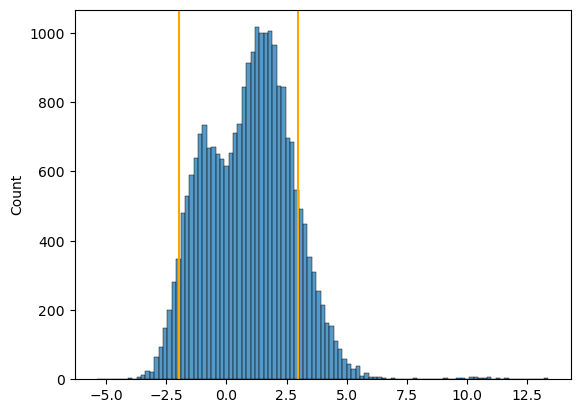

In [62]:
ax = sns.histplot(results_nat.fit.stan_variable("prediction").mean(0))
ax.axvline(x=results_nat.fit.stan_variable("cutpoint0").mean(0), color="orange")
_ = ax.axvline(x=np.exp(results_nat.fit.stan_variable("interval_size_logmean")).mean(0), color="orange")

This distribution can also be visualized in rating space. The blue histogram shows the predicted rating when not threshold by the cutpoints and the orange distribution shows the predicted rating when thresholded by the cutpoints.

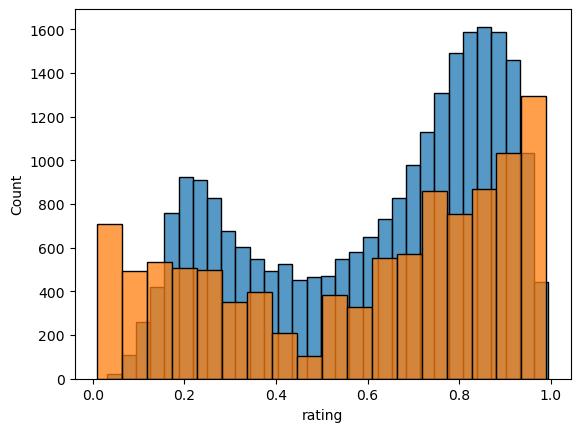

In [63]:
sns.histplot(results_nat.fit.stan_variable("interval_mean").mean(0))
_ = sns.histplot(data_nat[(data_nat.rating > 0) & (data_nat.rating < 100)].rating/100)

If we compare the orange distribution to the actual distribution in the dataset, we observe that ratings are quite a bit more sparse than predicted by the model–though the model correctly captures that 0 and 1 are the modes. 

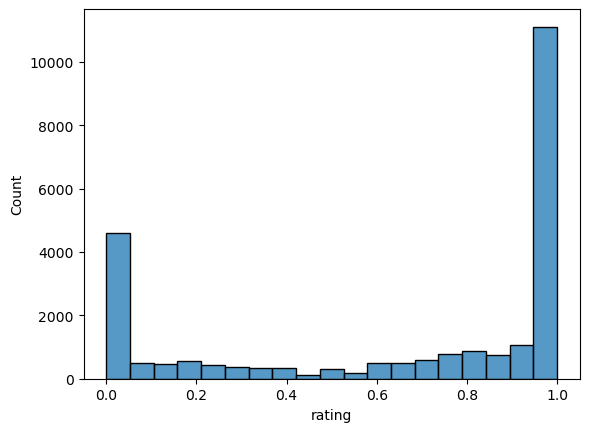

In [64]:
_ = sns.histplot(data_nat.rating/100)

## Experiment 2: Typicality

In [65]:
typ_fnames = [
    "typicality_llama-propbanksenses.csv",
    "typicality_llama-llamasenses.csv",
    "typicality_reddit.csv",
    "typicality_manual.csv"
]

data_typ = []

for fname in typ_fnames:
    df = pd.read_csv(f"data/{fname}")

    generation_method = fname.replace("typicality_", "").strip(".csv")

    if generation_method == "manual":
        df["generation_method_type"] = "manual"
        df["generation_method_subtype"] = "manual"
        df = df.query("sentence_type == 'target'")
        df["generation_method"] = "manual_" + df.naturalness + "_" + df.typicality
    else:
        df["generation_method_type"] = "automated"
        df["generation_method_subtype"] = generation_method
        df["generation_method"] = df[["sentence_type", "naturalness", "typicality"]].agg(
            lambda x: "manual_" + x.naturalness + "_" + x.typicality if x.sentence_type == "calibration" else generation_method,
            axis=1
        )

    data_typ.append(df)

data_typ = pd.concat(data_typ)

data_typ["rating_z"] = data_typ.groupby("rater_id").rating.transform(
    lambda x: (x - x.mean())/x.std()
)

data_typ["surprisal_z"] = (data_typ.surprisal - data_typ.surprisal.mean())/data_typ.surprisal.std()
data_typ["freq_z"] = (data_typ.freq - data_typ.freq.mean())/data_typ.freq.std()

data_typ

,rater_id,sentence,rating,sense,verb,typicality,naturalness,sentence_type,surprisal,freq,verbnet_class,generation_method_type,generation_method_subtype,generation_method,rating_z,surprisal_z,freq_z
0,56122d99-f13f-4674-a58a-5ece8f7973f6,The chef drove the limo.,37.0,drive.01: drive or be driven around in a vehicle,drive,atypical,natural,calibration,83.207458,3239,throw,automated,llama-propbanksense,manual_natural_atypical,-0.179108,-1.530222,0.348878
1,80e45189-916a-4f4a-9690-e83ef3ef5c2d,The chef drove the limo.,35.0,drive.01: drive or be driven around in a vehicle,drive,atypical,natural,calibration,83.207458,3239,throw,automated,llama-propbanksense,manual_natural_atypical,-0.477253,-1.530222,0.348878
2,58c5437e-7879-4200-9cf3-b1b892d47fd6,The chef drove the limo.,3.0,drive.01: drive or be driven around in a vehicle,drive,atypical,natural,calibration,83.207458,3239,throw,automated,llama-propbanksense,manual_natural_atypical,-1.294155,-1.530222,0.348878
3,6ad341a1-12e3-4a39-9ab0-77a32b7592bd,The chef drove the limo.,16.0,drive.01: drive or be driven around in a vehicle,drive,atypical,natural,calibration,83.207458,3239,throw,automated,llama-propbanksense,manual_natural_atypical,-1.101403,-1.530222,0.348878
4,0d04029d-6889-4a8f-a56c-c7f81cdb0b9a,The chef drove the limo.,51.0,drive.01: drive or be driven around in a vehicle,drive,atypical,natural,calibration,83.207458,3239,throw,automated,llama-propbanksense,manual_natural_atypical,-0.257870,-1.530222,0.348878
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6567,e3482363-c474-4acf-af4b-10c3bfdeba1f,The after tore the brick.,0.0,"tear.01: to pull apart, separate forcefully",tear,atypical,unnatural,target,194.907486,1030,hurt,manual,manual,manual_unnatural_atypical,-0.640775,0.874798,-1.098299
6568,e3482363-c474-4acf-af4b-10c3bfdeba1f,The athlete threw the javelin.,100.0,"throw.01: throw, sending through the air, manu...",throw,typical,natural,target,220.600510,3679,throw,manual,manual,manual_natural_typical,1.723989,1.427996,0.637134
6569,e3482363-c474-4acf-af4b-10c3bfdeba1f,The jellyfish threw the javelin.,0.0,"throw.01: throw, sending through the air, manu...",throw,atypical,natural,target,189.328308,3679,throw,manual,manual,manual_natural_atypical,-0.640775,0.754672,0.637134
6570,e3482363-c474-4acf-af4b-10c3bfdeba1f,The athlete threw the while.,0.0,"throw.01: throw, sending through the air, manu...",throw,typical,unnatural,target,224.713104,3679,throw,manual,manual,manual_unnatural_typical,-0.640775,1.516544,0.637134


In [66]:
expected_counts_typ = {
    "llama-llamasense": 97,
    "llama-propbanksense": 97,
    "manual": 124,
    "reddit": 72
}

data_typ = filter_participants(data_typ, expected_counts_typ)

data_typ

,rater_id,sentence,rating,sense,verb,typicality,naturalness,sentence_type,surprisal,freq,verbnet_class,generation_method_type,generation_method_subtype,generation_method,rating_z,surprisal_z,freq_z
0,56122d99-f13f-4674-a58a-5ece8f7973f6,The chef drove the limo.,37.0,drive.01: drive or be driven around in a vehicle,drive,atypical,natural,calibration,83.207458,3239,throw,automated,llama-propbanksense,manual_natural_atypical,-0.179108,-1.530222,0.348878
1,80e45189-916a-4f4a-9690-e83ef3ef5c2d,The chef drove the limo.,35.0,drive.01: drive or be driven around in a vehicle,drive,atypical,natural,calibration,83.207458,3239,throw,automated,llama-propbanksense,manual_natural_atypical,-0.477253,-1.530222,0.348878
2,58c5437e-7879-4200-9cf3-b1b892d47fd6,The chef drove the limo.,3.0,drive.01: drive or be driven around in a vehicle,drive,atypical,natural,calibration,83.207458,3239,throw,automated,llama-propbanksense,manual_natural_atypical,-1.294155,-1.530222,0.348878
3,6ad341a1-12e3-4a39-9ab0-77a32b7592bd,The chef drove the limo.,16.0,drive.01: drive or be driven around in a vehicle,drive,atypical,natural,calibration,83.207458,3239,throw,automated,llama-propbanksense,manual_natural_atypical,-1.101403,-1.530222,0.348878
4,0d04029d-6889-4a8f-a56c-c7f81cdb0b9a,The chef drove the limo.,51.0,drive.01: drive or be driven around in a vehicle,drive,atypical,natural,calibration,83.207458,3239,throw,automated,llama-propbanksense,manual_natural_atypical,-0.257870,-1.530222,0.348878
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6567,e3482363-c474-4acf-af4b-10c3bfdeba1f,The after tore the brick.,0.0,"tear.01: to pull apart, separate forcefully",tear,atypical,unnatural,target,194.907486,1030,hurt,manual,manual,manual_unnatural_atypical,-0.640775,0.874798,-1.098299
6568,e3482363-c474-4acf-af4b-10c3bfdeba1f,The athlete threw the javelin.,100.0,"throw.01: throw, sending through the air, manu...",throw,typical,natural,target,220.600510,3679,throw,manual,manual,manual_natural_typical,1.723989,1.427996,0.637134
6569,e3482363-c474-4acf-af4b-10c3bfdeba1f,The jellyfish threw the javelin.,0.0,"throw.01: throw, sending through the air, manu...",throw,atypical,natural,target,189.328308,3679,throw,manual,manual,manual_natural_atypical,-0.640775,0.754672,0.637134
6570,e3482363-c474-4acf-af4b-10c3bfdeba1f,The athlete threw the while.,0.0,"throw.01: throw, sending through the air, manu...",throw,typical,unnatural,target,224.713104,3679,throw,manual,manual,manual_unnatural_typical,-0.640775,1.516544,0.637134


In [73]:
if glob("fits/typ/base/*.csv"):
    results_typ = load_fit(
        "fits/typ/base/*.csv", 
        data_nat,
        fixed_formula="~ 1 + C(generation_method, levels=generation_levels)",
        by_subj_formula="~ 1", # cannot fit anything bigger, because not all subjects saw items from every generation method
        by_verb_formula="~ 1", # cannot fit anything bigger, because not all verbs show up with each generation method
        by_sense_formula="~ 1", # cannot fit anything bigger, because not all verb senses show up with each generation method
        by_item_formula="~ 1", # cannot fit anything bigger, because items are specific to generation method
        item_cols = ["sentence"],
        subj_cols = ["rater_id"],
        verb_cols = ["verb"],
        sense_cols = ["verb", "sense"],
    )
else:
    results_typ = fit_hmc(
        data_typ,
        fixed_formula="~ 1 + C(generation_method, levels=generation_levels)",
        by_subj_formula="~ 1", # cannot fit anything bigger, because not all subjects saw items from every generation method
        by_verb_formula="~ 1", # cannot fit anything bigger, because not all verbs show up with each generation method
        by_sense_formula="~ 1", # cannot fit anything bigger, because not all verb senses show up with each generation method
        by_item_formula="~ 1", # cannot fit anything bigger, because items are specific to generation method
        item_cols = ["sentence"],
        subj_cols = ["rater_id"],
        verb_cols = ["verb"],
        sense_cols = ["verb", "sense"],
        output_dir="fits/typ/base/",
        **sampler_params
    )

    results_typ.fit.diagnose()

    # handles a bug in cmdstanpy.from_csv that I suspect has to do with a version change in STAN
    # basically, I *think* STAN used to dump the save_warmup flag as an int, but now it uses a boolean
    !find . -type f -wholename './fits/typ/base/*.csv' | xargs sed -i 's/save_warmup = false/save_warmup = 0/g'

12:24:03 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 10 divergent transitions (100.0%)
	Chain 2 had 10 divergent transitions (100.0%)
	Chain 3 had 10 divergent transitions (100.0%)
	Use function "diagnose()" to see further information.


In [74]:
results_typ.fixed_coefs

,post_mean,2.5%,5%,95%,97.5%,p
Intercept,1.014496,-0.444841,-0.444841,2.386700,2.386700,0.250
"C(generation_method, levels=generation_levels)[T.manual_natural_atypical]",-2.231516,-3.584779,-3.576983,-0.668876,-0.614844,0.025
"C(generation_method, levels=generation_levels)[T.manual_unnatural_typical]",-1.642984,-3.756852,-3.675925,1.135630,1.135630,0.275
"C(generation_method, levels=generation_levels)[T.manual_unnatural_atypical]",-2.692788,-4.568664,-4.381506,-0.751937,-0.711887,0.025
"C(generation_method, levels=generation_levels)[T.reddit]",-0.685216,-1.850530,-1.850530,0.294521,0.346242,0.250
"C(generation_method, levels=generation_levels)[T.llama-propbanksense]",-0.939723,-1.827170,-1.822562,0.372828,0.373747,0.250
"C(generation_method, levels=generation_levels)[T.llama-llamasense]",-0.983176,-1.917184,-1.916920,0.262361,0.264504,0.225


In [69]:
print_fixed_coef_tabular(results_typ, process_coef_name_nat_typ)

\begin{tabular}{rcccr}
\toprule
      & \textbf{Post. mean} & \textbf{2.5\%} & \textbf{97.5\%} & \textbf{Post.} $p$ \\
\midrule
Intercept & 1.01 & -0.44 & 2.39 & 0.25 \\
Manual (Natural \& Atypical) & -2.23 & -3.58 & -0.61 & 0.03 \\
Manual (Unnatural \& Typical) & -1.64 & -3.76 & 1.14 & 0.28 \\
Manual (Unnatural \& Atypical) & -2.69 & -4.57 & -0.71 & 0.03 \\
Corpus & -0.69 & -1.85 & 0.35 & 0.25 \\
LM with PropBank senses & -0.94 & -1.83 & 0.37 & 0.25 \\
LM with LM senses & -0.98 & -1.92 & 0.26 & 0.23 \\
\bottomrule
\end{tabular}


In [70]:
_ = cutpoint_stats(results_typ.fit)

Cutpoint 0: -1.8 (95\% CI = [-5.81, -0.99])
Cutpoint 1: 1.3 (95\% CI = [-5.62, 1.75])


### Predicting typicality from frequency and surprisal

In [97]:
data_typ_freqsurp = data_typ[["sentence", "freq_z", "surprisal_z"]].drop_duplicates()

mod_surprisal_z_resid_freq_z = LinearRegression().fit(
    data_typ_freqsurp[["freq_z"]], data_typ_freqsurp[["surprisal_z"]]
)

data_typ_freqsurp["surprisal_z_resid_freq_z"] = data_typ_freqsurp[["surprisal_z"]] -\
    mod_surprisal_z_resid_freq_z.predict(data_typ_freqsurp[["freq_z"]])

data_typ_surp_resid = pd.merge(data_typ, data_typ_freqsurp[["sentence", "surprisal_z_resid_freq_z"]])

assert data_typ.shape[0] == data_typ_surp_resid.shape[0]

data_typ_surp_resid

,rater_id,sentence,rating,sense,verb,typicality,naturalness,sentence_type,surprisal,freq,verbnet_class,generation_method_type,generation_method_subtype,generation_method,rating_z,surprisal_z,freq_z
0,56122d99-f13f-4674-a58a-5ece8f7973f6,The chef drove the limo.,37.0,drive.01: drive or be driven around in a vehicle,drive,atypical,natural,calibration,83.207458,3239,throw,automated,llama-propbanksense,manual_natural_atypical,-0.179108,-1.530222,0.348878
1,80e45189-916a-4f4a-9690-e83ef3ef5c2d,The chef drove the limo.,35.0,drive.01: drive or be driven around in a vehicle,drive,atypical,natural,calibration,83.207458,3239,throw,automated,llama-propbanksense,manual_natural_atypical,-0.477253,-1.530222,0.348878
2,58c5437e-7879-4200-9cf3-b1b892d47fd6,The chef drove the limo.,3.0,drive.01: drive or be driven around in a vehicle,drive,atypical,natural,calibration,83.207458,3239,throw,automated,llama-propbanksense,manual_natural_atypical,-1.294155,-1.530222,0.348878
3,6ad341a1-12e3-4a39-9ab0-77a32b7592bd,The chef drove the limo.,16.0,drive.01: drive or be driven around in a vehicle,drive,atypical,natural,calibration,83.207458,3239,throw,automated,llama-propbanksense,manual_natural_atypical,-1.101403,-1.530222,0.348878
4,0d04029d-6889-4a8f-a56c-c7f81cdb0b9a,The chef drove the limo.,51.0,drive.01: drive or be driven around in a vehicle,drive,atypical,natural,calibration,83.207458,3239,throw,automated,llama-propbanksense,manual_natural_atypical,-0.257870,-1.530222,0.348878
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6001,c216cbb2-c324-4d1f-adad-854f8860c94d,The chef drove the limo.,5.0,drive.01: drive or be driven around in a vehicle,drive,atypical,natural,target,161.152435,3239,throw,manual,manual,manual_natural_atypical,-0.569569,0.148016,0.348878
6125,5cb832f6-831e-48fc-95e0-d7413b9dd9da,The chef drove the limo.,95.0,drive.01: drive or be driven around in a vehicle,drive,atypical,natural,target,161.152435,3239,throw,manual,manual,manual_natural_atypical,1.395946,0.148016,0.348878
6249,11cfdccf-cb96-4f83-b70e-5fb49fc566d0,The chef drove the limo.,28.0,drive.01: drive or be driven around in a vehicle,drive,atypical,natural,target,161.152435,3239,throw,manual,manual,manual_natural_atypical,-0.142133,0.148016,0.348878
6373,f9e3e75b-1a62-4e2e-b10f-1541a0406cf0,The chef drove the limo.,25.0,drive.01: drive or be driven around in a vehicle,drive,atypical,natural,target,161.152435,3239,throw,manual,manual,manual_natural_atypical,-0.482529,0.148016,0.348878


In [108]:
if glob("fits/typ/frequency_surprisal/*.csv"):
    results_typ_freqsurp = load_fit(
        "fits/typ/frequency_surprisal/*.csv",
        data_typ,
        fixed_formula="~ 1 + C(generation_method, levels=generation_levels) * (freq_z + surprisal_z)",
        by_subj_formula="~ 1 + freq_z + surprisal", # cannot fit anything bigger, because not all subjects saw items from every generation method
        by_verb_formula="~ 1 + surprisal_z", # cannot fit anything bigger, because not all verbs show up with each generation method
        by_sense_formula="~ 1 + surprisal_z", # cannot fit anything bigger, because not all verb senses show up with each generation method
        by_item_formula="~ 1", # cannot fit anything bigger, because items are specific to generation method
        item_cols = ["sentence"],
        subj_cols = ["rater_id"],
        verb_cols = ["verb"],
        sense_cols = ["verb", "sense"]
    )
else:
    results_typ_freqsurp = fit_hmc(
        data_typ,
        fixed_formula="~ 1 + C(generation_method, levels=generation_levels) * (freq_z + surprisal_z)",
        by_subj_formula="~ 1 + freq_z + surprisal", # cannot fit anything bigger, because not all subjects saw items from every generation method
        by_verb_formula="~ 1 + surprisal_z", # cannot fit anything bigger, because not all verbs show up with each generation method
        by_sense_formula="~ 1 + surprisal_z", # cannot fit anything bigger, because not all verb senses show up with each generation method
        by_item_formula="~ 1", # cannot fit anything bigger, because items are specific to generation method
        item_cols = ["sentence"],
        subj_cols = ["rater_id"],
        verb_cols = ["verb"],
        sense_cols = ["verb", "sense"],
        output_dir="fits/typ/frequency_surprisal",
        **sampler_params
    )

    results_typ_freqsurp.fit.diagnose()

    # handles a bug in cmdstanpy.from_csv that I suspect has to do with a version change in STAN
    # basically, I *think* STAN used to dump the save_warmup flag as an int, but now it uses a boolean
    !find . -type f -wholename './fits/typ/frequency_surprisal/*.csv' | xargs sed -i 's/save_warmup = false/save_warmup = 0/g'

12:58:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:59:37 - cmdstanpy - INFO - CmdStan done processing.
12:59:37 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: lkj_corr_lpdf: Correlation matrix is not positive definite. (in '/home/jovyan/scripts/analysis/models/ordered-beta.stan', line 121, column 2 to column 26)
	Exception: lkj_corr_lpdf: Correlation matrix is not positive definite. (in '/home/jovyan/scripts/analysis/models/ordered-beta.stan', line 121, column 2 to column 26)
	Exception: lkj_corr_lpdf: Correlation matrix is not positive definite. (in '/home/jovyan/scripts/analysis/models/ordered-beta.stan', line 121, column 2 to column 26)
	Exception: lkj_corr_lpdf: Correlation matrix is not positive definite. (in '/home/jovyan/scripts/analysis/models/ordered-beta.stan', line 121, column 2 to column 26)
	Exception: lkj_corr_lpdf: Correlation matrix is not positive definite. (in '/home/jovyan/scripts/analysis/models/ordered-beta.stan', line 121, column 2 to column 26)
	Exception: lkj_corr_lpdf: Correlation matrix

12:59:37 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 2 had 10 divergent transitions (100.0%)
	Chain 3 had 10 divergent transitions (100.0%)
	Chain 4 had 2 iterations at max treedepth (20.0%)
	Use function "diagnose()" to see further information.


In [109]:
results_typ_freqsurp.fixed_coefs

,post_mean,2.5%,5%,95%,97.5%,p
Intercept,1.789680,0.540520,0.557507,2.392507,2.638811,0.000
"C(generation_method, levels=generation_levels)[T.manual_natural_atypical]",-3.368531,-4.380415,-4.324728,-0.035809,-0.015589,0.000
"C(generation_method, levels=generation_levels)[T.manual_unnatural_typical]",-3.572342,-4.340825,-4.312204,-1.287897,-1.287427,0.000
"C(generation_method, levels=generation_levels)[T.manual_unnatural_atypical]",-3.987906,-4.901836,-4.797115,-1.234123,-1.226196,0.000
"C(generation_method, levels=generation_levels)[T.reddit]",-0.851224,-1.603015,-1.539312,0.642489,0.646166,0.125
"C(generation_method, levels=generation_levels)[T.llama-propbanksense]",-0.918702,-1.612565,-1.610260,1.491118,1.494124,0.175
"C(generation_method, levels=generation_levels)[T.llama-llamasense]",-1.276115,-1.812642,-1.801970,0.019082,0.562012,0.050
freq_z,0.195489,-0.549314,-0.475793,1.081785,1.189853,0.425
"C(generation_method, levels=generation_levels)[T.manual_natural_atypical]:freq_z",0.109129,-0.605743,-0.447864,1.797711,1.841143,0.475
"C(generation_method, levels=generation_levels)[T.manual_unnatural_typical]:freq_z",-0.463143,-1.495159,-1.478491,0.274745,0.298480,0.300


### Predict naturalness from typicality

In [76]:
data_typ_mean = data_typ.pivot_table(
    index="sentence", values="rating_z", aggfunc=np.mean
).rename(
    columns={"rating_z": "typicality_rating"}
).reset_index()

data_typ_mean

,sentence,typicality_rating
0,The ALA cast the muppets.,-0.548768
1,The Americans abused the Mexicans.,0.205448
2,The Americans beat the Japanese.,0.611064
3,The BBC covered the inauguration.,1.029906
4,The Baudelaires encountered the unknown.,-0.048643
...,...,...
1835,The youngest met the queen.,0.561288
1836,The youngster pinched the cat.,0.711491
1837,The youngster reached the age.,-0.121412
1838,The youngster saw the girl.,0.771561


In [77]:
data_nat_typ = pd.merge(data_nat, data_typ_mean, how="left")

data_nat_typ

,rater_id,sentence,rating,sense,verb,typicality,naturalness,sentence_type,surprisal,freq,verbnet_class,generation_method_type,generation_method_subtype,generation_method,surprisal_z,freq_z,typicality_rating
0,83bda277-9b4f-4c6e-a23b-a79ece20cc5c,The baby arranged the something.,50.0,arrange.01: build,arrange,typical,unnatural,calibration,127.474388,2289,build,automated,llama-propbanksense,manual_unnatural_typical,-0.730774,-0.240193,0.087812
1,8bc64c84-3e28-4f83-abaf-e585ff40ffe5,The baby arranged the something.,0.0,arrange.01: build,arrange,typical,unnatural,calibration,127.474388,2289,build,automated,llama-propbanksense,manual_unnatural_typical,-0.730774,-0.240193,0.087812
2,f09582f5-d39c-41eb-ab67-ff696f2c3459,The baby arranged the something.,22.0,arrange.01: build,arrange,typical,unnatural,calibration,127.474388,2289,build,automated,llama-propbanksense,manual_unnatural_typical,-0.730774,-0.240193,0.087812
3,e41ede6f-b8a8-4424-a276-520d63d0af85,The baby arranged the something.,0.0,arrange.01: build,arrange,typical,unnatural,calibration,127.474388,2289,build,automated,llama-propbanksense,manual_unnatural_typical,-0.730774,-0.240193,0.087812
4,03eaf938-1208-40ce-9b0b-bb58cc6048c9,The baby arranged the something.,0.0,arrange.01: build,arrange,typical,unnatural,calibration,127.474388,2289,build,automated,llama-propbanksense,manual_unnatural_typical,-0.730774,-0.240193,0.087812
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24424,48938107-ae25-4ac5-af1f-f5552d1228a9,The after tore the brick.,25.0,"tear.01: to pull apart, separate forcefully",tear,atypical,unnatural,target,194.907486,1030,hurt,manual,manual,manual_unnatural_atypical,0.885373,-1.088339,-0.753087
24425,48938107-ae25-4ac5-af1f-f5552d1228a9,The athlete threw the javelin.,100.0,"throw.01: throw, sending through the air, manu...",throw,typical,natural,target,220.600510,3679,throw,manual,manual,manual_natural_typical,1.501149,0.696203,0.995130
24426,48938107-ae25-4ac5-af1f-f5552d1228a9,The jellyfish threw the javelin.,92.0,"throw.01: throw, sending through the air, manu...",throw,atypical,natural,target,189.328308,3679,throw,manual,manual,manual_natural_atypical,0.751658,0.696203,-0.633328
24427,48938107-ae25-4ac5-af1f-f5552d1228a9,The athlete threw the while.,38.0,"throw.01: throw, sending through the air, manu...",throw,typical,unnatural,target,224.713104,3679,throw,manual,manual,manual_unnatural_typical,1.599714,0.696203,-0.786691


In [81]:
if glob("fits/nat/typicality/*.csv"):
    results_nat_typ = load_fit(
        "fits/nat/typicality/*.csv", 
        data_nat_typ,
        fixed_formula="~ 1 + typicality_rating",
        by_subj_formula="~ 1 + typicality_rating",
        by_verb_formula="~ 1 + typicality_rating",
        by_sense_formula="~ 1 + typicality_rating", 
        by_item_formula="~ 1", # cannot fit anything bigger, because each sentence has only one typicality rating
        item_cols = ["sentence"],
        subj_cols = ["rater_id"],
        verb_cols = ["verb"],
        sense_cols = ["verb", "sense"],
    )
else:
    results_nat_typ = fit_hmc(
        data_nat_typ,
        fixed_formula="~ 1 + typicality_rating",
        by_subj_formula="~ 1 + typicality_rating",
        by_verb_formula="~ 1 + typicality_rating",
        by_sense_formula="~ 1 + typicality_rating", 
        by_item_formula="~ 1", # cannot fit anything bigger, because each sentence has only one typicality rating
        item_cols = ["sentence"],
        subj_cols = ["rater_id"],
        verb_cols = ["verb"],
        sense_cols = ["verb", "sense"],
        output_dir="fits/nat/typicality",
        **sampler_params
    )

    results_nat_typ.fit.diagnose()

    # handles a bug in cmdstanpy.from_csv that I suspect has to do with a version change in STAN
    # basically, I *think* STAN used to dump the save_warmup flag as an int, but now it uses a boolean
    !find . -type f -wholename './fits/nat/typicality/*.csv' | xargs sed -i 's/save_warmup = false/save_warmup = 0/g'

12:30:11 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 3 iterations at max treedepth (30.0%)
	Chain 2 had 9 divergent transitions (90.0%)
	Chain 3 had 5 iterations at max treedepth (50.0%)
	Chain 4 had 10 divergent transitions (100.0%)
	Use function "diagnose()" to see further information.


In [82]:
results_nat_typ.fixed_coefs

,post_mean,2.5%,5%,95%,97.5%,p
Intercept,0.965728,-0.528811,-0.457259,1.734128,1.742895,0.1
typicality_rating,0.769775,-1.393435,-1.265746,1.974613,2.068462,0.4


## Distinctiveness

In [ ]:
diff_fnames = [
    "difference_llama-propbanksenses.csv",
    "difference_llama-llamasenses.csv",
    "difference_reddit.csv",
    "difference_manual.csv"
]

data_diff = []

for fname in diff_fnames:
    df = pd.read_csv(f"data/{fname}")

    df["generation_method"] = fname.replace("difference_", "").strip(".csv")

    data_diff.append(df)

data_diff = pd.concat(data_diff)

data_diff["surprisal1_z"] = (data_diff.surprisal1 - data_diff.surprisal1.mean())/data_diff.surprisal1.std()
data_diff["surprisal2_z"] = (data_diff.surprisal2 - data_diff.surprisal2.mean())/data_diff.surprisal2.std()

data_diff["freq_z"] = (data_diff.freq - data_diff.freq.mean())/data_diff.freq.std()

data_diff["logfreq"] = np.log1p(data_diff["freq"].fillna(0))
data_diff["logfreq_z"] = (data_diff.logfreq - data_diff.logfreq.mean())/data_diff.logfreq.std()

if data_diff.sense1.isnull().any() or data_diff.sense2.isnull().any():
    print("Inserting random dummy senses.")
    data_diff["sense1"] = np.random.choice(100, size=data_diff.shape[0]).astype(str)
    data_diff["sense2"] = np.random.choice(100, size=data_diff.shape[0]).astype(str)

if (data_diff.comparison == "filler").any():
    data_diff_automated_calibration = data_diff[data_diff.pair_type=="filler"].drop(columns=["comparison"])

    data_diff_automated_calibration = pd.merge(
        data_diff_automated_calibration ,
        data_diff[data_diff.generation_method=="manual"][["sentence1", "sentence2", "comparison"]].drop_duplicates()
    )

    data_diff = pd.concat(
        [data_diff[data_diff.pair_type != "filler"], data_diff_automated_calibration],
        axis=0
    )

data_diff

In [ ]:
generation_levels = [
    'manual', 'reddit', 'llama-propbanksense', 'llama-llamasense'
]

comparison_levels = ['same', 'different']

fit_pairdiff = fit_hmc(
    data_diff,
    fixed_formula="~ 1 + C(comparison, levels=comparison_levels) * C(generation_method, levels=generation_levels)",
    by_subj_formula="~ 1 + C(comparison, levels=comparison_levels)",
    by_verb_formula="~ 1 + C(comparison, levels=comparison_levels)",
    by_sense_formula="~ 1", 
    by_item_formula="~ 1",
    item_cols=["sentence1", "sentence2"],
    sense_cols = ["verb", "sense1", "sense2"],
    subj_cols=["rater_id"],
    verb_cols = ["verb"],
    output_dir="fits/pairdiff/base/",
    **sampler_params
)

In [ ]:
fit_pairdiff["fixed_coefs"]

In [ ]:
def process_coef_name_pairdiff(coef: str) -> str:
    coef_map = {
        "manual": "Manual",
        "reddit": "Corpus",
        "llama-propbanksense": "LM with PropBank senses",
        "llama-llamasense": "LM with LM senses",
        "different": "Different Sense",
        "same": "Same Sense"
    }

    if coef == "Intercept":
        return coef
    else:
        return " $\\times$ ".join(
            coef_map[v] for v in re.findall(
                "C\(.*?\)\[T\.(.*?)\]", 
                coef
            )
        )

print_fixed_coef_tabular(fit_pairdiff, process_coef_name_pairdiff)

In [ ]:
cutpoint0_pairdiff = fit_pairdiff["fit"].stan_variable("cutpoint0")

print(
    np.round(cutpoint0_pairdiff.mean(0), 2), 
    f"[{np.round(np.quantile(cutpoint0_pairdiff, 0.025), 2)}, {np.round(np.quantile(cutpoint0_pairdiff, 0.975), 2)}]"
)

In [ ]:
cutpoint1_pairdiff = cutpoint0_pairdiff + np.exp(fit_pairdiff["fit"].stan_variable("interval_size_logmean"))

print(
    np.round(cutpoint1_pairdiff.mean(0), 2), 
    f"[{np.round(np.quantile(cutpoint1_pairdiff, 0.025), 2)}, {np.round(np.quantile(cutpoint1_pairdiff, 0.975), 2)}]"
)

In [ ]:
_ = arviz.plot_posterior(fit_pairdiff["fit"], var_names=["fixed_coefs"])

In [ ]:
_ = arviz.plot_posterior(fit_pairdiff["fit"], var_names=["subj_scale", "item_scale", "verb_scale"])

In [ ]:

_ = arviz.plot_posterior(fit_pairdiff["fit"], var_names=["sample_size", "interval_size"])

In [ ]:
fit_pairdiff_surprisal = fit_hmc(
    data_diff,
    fixed_formula=("~ 1 + C(PairType, levels=comparison_levels) * surprisal1_z * surprisal2_z"
                      " + C(PairType, levels=comparison_levels) * typicality1 * typicality2" 
                      " + C(PairType, levels=comparison_levels) * freq"),
    by_subj_formula="~ 1 + C(PairType, levels=comparison_levels)",
    by_verb_formula="~ 1 + C(PairType, levels=comparison_levels)",
    by_sense_formula="~ 1", 
    by_item_formula="~ 1", 
    max_init_iter=0,
    item_cols=["sentence1", "sentence2"],
    sense_cols = ["verb", "sense1", "sense2"],
    subj_cols=["rater_id"],
    verb_cols = ["verb"],
    output_dir="fits/pairdiff/",
    **sampler_params
)

In [ ]:
fit_pairdiff_surprisal["fixed_coefs"]

In [ ]:
print_fixed_coef_tabular(fit_pairdiff_surprisal, process_coef_name_pairdiff_surprisal)

In [ ]:
_ = arviz.plot_posterior(fit_pairdiff_surprisal["fit"], var_names=["fixed_coefs"])

In [ ]:
_ = arviz.plot_posterior(fit_pairdiff_surprisal["fit"], var_names=["subj_scale", "item_scale", "verb_scale"])

In [ ]:

_ = arviz.plot_posterior(fit_pairdiff_surprisal["fit"], var_names=["sample_size", "interval_size"])